### Setup and import data

In [1]:
# import dependencies
import torch
from torch import nn
print(torch.__version__)
import requests
import zipfile
from pathlib import Path

1.12.0


In [2]:
def device_agnostic():
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device("mps")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    print("Device:", device)
    return device

device = device_agnostic()

Device: cpu


In [3]:
# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        
        zip_ref.extractall(image_path)

data\pizza_steak_sushi directory exists.


In [4]:
# Walk through the image directory
import os
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")
walk_through_dir(image_path)

There are 2 directories and 0 images in data\pizza_steak_sushi
There are 3 directories and 0 images in data\pizza_steak_sushi\test
There are 0 directories and 25 images in data\pizza_steak_sushi\test\pizza
There are 0 directories and 19 images in data\pizza_steak_sushi\test\steak
There are 0 directories and 31 images in data\pizza_steak_sushi\test\sushi
There are 3 directories and 0 images in data\pizza_steak_sushi\train
There are 0 directories and 78 images in data\pizza_steak_sushi\train\pizza
There are 0 directories and 75 images in data\pizza_steak_sushi\train\steak
There are 0 directories and 72 images in data\pizza_steak_sushi\train\sushi


In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

data\pizza_steak_sushi\train\sushi\385154.jpg
sushi
Path: data\pizza_steak_sushi\train\sushi\385154.jpg
Class: sushi
Size: (512, 382)


(-0.5, 511.5, 381.5, -0.5)

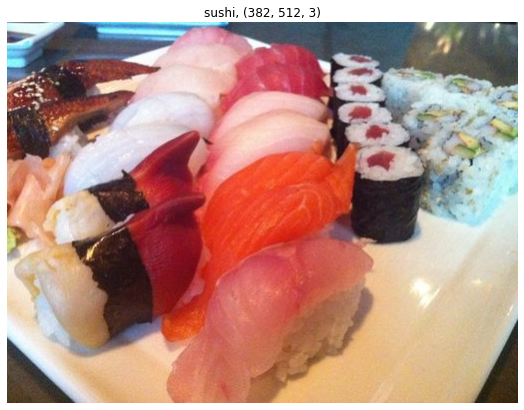

In [6]:
import random
from PIL import Image
import numpy as np

# Set the random seed to make sure the results are reproducible
#random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)
print(random_image_path)
image_class = random_image_path.parent.name # OR .stem
 
print(image_class)

img = Image.open(random_image_path)

print(f"Path: {random_image_path}")
print(f"Class: {image_class}")
print(f"Size: {img.size}")
img

import matplotlib.pyplot as plt

img_as_array = np.array(img)
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"{image_class}, {img_as_array.shape}")
plt.axis("off")

### Transforming the data and setup the dataloader

In [7]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [8]:
from torchvision import transforms

# From pytorch website:
# train_transform = transforms.Compose([
#     transforms.Resize(299),
#     transforms.CenterCrop(299),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# train_transform = transforms.Compose(
#     [
#         transforms.Resize(299),
#         transforms.TrivialAugmentWide(num_magnitude_bins=10),
#         transforms.ToTensor(),
#     ]
# )

# test_transform = transforms.Compose(
#     [transforms.Resize((299)), transforms.ToTensor()]
# )

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(299),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = train_transform

from torchvision import datasets

train_data_simple = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=test_transform)

# Turn datasets into dataloaders
import os
from torch.utils.data import DataLoader

# Set batch size and number of workers
BATCH_SIZE = 1
NUM_WORKERS = os.cpu_count()
print(f"Using {NUM_WORKERS} workers")
train_dataloader_simple = DataLoader(
    dataset=train_data_simple,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    drop_last=True,
    shuffle=True,
)
test_dataloader_simple = DataLoader(
    dataset=test_data_simple,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    drop_last=True , # drop the last incomplete batch if the dataset size is not divisible by the batch size
    shuffle=False,
)

Using 8 workers


### Our model

In [9]:
# Imprting InceptionV3 model for transfer learning
from pickletools import optimize
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)

Using cache found in C:\Users\pouya/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\pouya\miniconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\pouya\miniconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
model.aux_logits = (
    False  # Remove auxiliary classifier layer, They are used when training on Imagenet
)

for param in model.parameters():
    param.requires_grad = False  # Freeze all the parameters

num_ftrs = model.fc.in_features  # Get the number of features of the last layer

model.fc = nn.Linear(
    num_ftrs, 3
)  # Replace the last layer with a linear layer with 3 outputs
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
# import torchinfo
# torchinfo.summary(model, input_size=(3, 299, 299))

### Training and testing steps 

In [12]:
# Train_step
from rich.progress import track


def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
):
    model.train()

    # set up loss and train accuracy

    train_loss, train_acc = 0, 0
    # Make the track bar delete after it's done

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)
        # 23:20:58
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        # Calculate accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(
            y_pred
        )  # <- this is the same as torch.sum(y_pred_class == y) / len(y_pred)
    # Adjust metrics to get average loss and accuracy per batch

    train_loss = train_loss / len(
        dataloader
    )  # <- len(dataloader) is the number of batches in the dataloader
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [13]:
# Test_step
def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device=device,
):
    # Model to eval mode
    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():

        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Forward pass
            test_pred_logits = model(X)

            # Calculate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate accuracy
            test_pred_labels = test_pred_logits.argmax(
                dim=1
            )  # <- softmax is not needed for argmax
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

    test_loss = test_loss / len(
        dataloader
    )  # <- len(dataloader) is the number of batches in the dataloader
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [14]:
# Train Function
def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int = 5,
):
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    from timeit import default_timer as timer

    for epoch in track(range(epochs)):
        epoch_train_time = timer()
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer)
        epoch_test_time = timer()
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn)
        epoch_stop_time = timer()
        print(
            f"Epoch {epoch + 1}/{epochs} |"
            f"Train_loss: {train_loss:.4f} |"
            f"train_acc: {train_acc:.4f} |"
            f"test_loss: {test_loss:.4f} |"
            f"test_acc: {test_acc:.4f} |\n"
            f"train time: {epoch_test_time -epoch_train_time:.4f} secs |"
            f"test time: {epoch_stop_time - epoch_test_time :.4f} secs |"
            f"total time: {epoch_stop_time - epoch_train_time:.4f} secs |\n"
            f"------------------------------------------------------"
        )
        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

### Training the model

In [15]:

NUM_EPOCHES = 5

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
from timeit import default_timer as timer

timer_start = timer()  # 🕑

model_0_results = train(
    model,
    train_dataloader_simple,
    test_dataloader_simple,
    optimizer,
    loss_fn,
    NUM_EPOCHES,
)

timer_stop = timer()  # 🕑

print(f"Training took {timer_stop - timer_start:.3f} seconds or {(timer_stop - timer_start) / 60:.3f} minutes on device {device}")

Output()

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 768, 1, 1])